# MADM Notebook
## Main questions of interest:
<ol> 
<li>Which descriptors best predict potency?  How do we validate these?
    <ul>
    <li><strong>F-statistic</strong>; H0: There does not exist a relationship between regression parameters. Ha: There does exist a relationship between regression parameters.</li>
    <li><strong>Mixed Selection (pvalues)</strong>; Best indendent dimensions p-values in OLS.</li>
    <li><strong>Forward Selection R^2</strong>; Best mix of columns to maximize R^2.</li>
    <li><strong>Lasso</strong>; Gridsearch lambda let lasso drop dimensions, plot results.</li>
    <li><strong>PCA</strong>; Consider a PCA on all dimensions EXCLUDED from the methods above, this way we can still capture the most gain from the other dimensions if we want too instead of just dropping them.</li>
    <li>[...]</li>
    <li>[...]</li>
    </ul> 
</li>

<li>Can we augment the data set with predicted negative data (molecules expected to be inactive) to improve our machine learning models? Are there certain characteristics of negative data sets that are the most useful for training?
    <ul>
        <li>What value should IC50 be filled with (zero?)</li>
        <li>What attributes relate most to the negative data?</li>
        <li>Explore similar techniques from (1)</li>
        <li><strong>K=2</strong>; Now we know for sure there is a binary partition in the data, because we manufactured it.</li>
        <li><strong>SVM</strong>; We also know that a p-space hyperplace should classify this into two groups, making SVM a valuable option as well.</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul>
</li>

<li>Given the limited size of the data set and the high cost of experiments, can we use ML to identify the missing data that would be best for model training?
    <ul>
        <li><strong>KNR</strong>; What are my 5 nearest neighbors, make me interpolate me like them.</li>
        <li><strong>Bayes</strong> (Posterior Probabiliy); bin the response, Find max likelihood of me being in that bin, if I am in that bin, grab everyone else in that bin and draw a probability of me like that bins mean/std.</li>
        <li><strong>Naive Bayes</strong> (Posterior Probabiliy); same logic as bayes except independence assumption.</li>
        <li><strong>Markov Chains</strong>; DTMC or CTMC; Based on these probabilities, Assess what the steady state distribution will look like of me <em>bin</em> changing based on the training data's behavior.</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul>
</li>
<li>Which cluster most closely with OSM-S-106?
    <ul>
        <em>k=2; negative data set and positive dataset.</em>
        <li><strong>Heirarchical Clustering</strong>; How does our heirarchy build and classify?</li>
        <li><strong>EM Clustering</strong>; Take variance into account</li>
        <li><strong>K-means</strong>; Baseline</li>
        <li><strong>KNN</strong>; Do we have nearest neigbors from the negative data?</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul>
</li>
<li>Would this provide clues as to the mechanism of OSM-S-106?
    <ul>
        <li>Mixed Selection (pvalues)</li>
        <li>Forward Selection R^2</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul>
</li>
<li>How well do more advanced ML models perform over simple methods like multiple linear regression, SVM, and random forest?
    <ul>
        <li><strong>Random Forest</strong>; Gridsearch number of trees, How do these forests segment our data.</li>
        <li><strong>Adaboost</strong>; Gridsearch alpha (learning rate). Let this guy perfectly fit the data and see how it segments trees for exploratory reasons.</li>
        <li> <strong>Neural Network</strong>; Gridsearch layers. Traditionally they don't do good on this type of problem, but the black box never ceases to amaze in p-space.</li>
        <li>[...]</li>
        <li>[...]</li>
    </ul></li>
</ol>

## Import Libraries
<hr>

In [5]:
# Core
import numpy as np
import pandas as pd
import os
import subprocess
def install_package(name):
    sudoPassword = ''
    command = 'pip install ' + name
    p = os.system('echo %s|sudo -S %s' % (sudoPassword, command))

# Stats
from statsmodels.regression import linear_model
import statsmodels.api as sm

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# OR
from skcriteria import Data, MIN, MAX
from skcriteria.madm import closeness, simple

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *

In [6]:
# Read in main data
main_df = pd.read_csv("Series3_6.15.17_padel.csv")

# Read in placebos data
placebo_1 = pd.read_csv("Akt1_decoys_padel.csv")
placebo_2 = pd.read_csv("AmpC_decoys_padel.csv")
placebo_3 = pd.read_csv("cp3a4_decoys_padel.csv")
placebo_4 = pd.read_csv("cxcr4_decoys_padel.csv")
placebo_5 = pd.read_csv("HIVpr_decoys_padel.csv")
placebo_6 = pd.read_csv("HIVrt_decoys_padel.csv")
placebo_7 = pd.read_csv("Kif11_decoys_padel.csv")
placebo_8 = pd.read_csv("Selleck_filtered_padel_corrected.csv")

# Append dumby response column.
placebo_1.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_1.shape[0])], dtype="float64"))) 
placebo_2.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_2.shape[0])], dtype="float64"))) 
placebo_3.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_3.shape[0])], dtype="float64"))) 
placebo_4.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_4.shape[0])], dtype="float64"))) 
placebo_5.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_5.shape[0])], dtype="float64"))) 
placebo_6.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_6.shape[0])], dtype="float64"))) 
placebo_7.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_7.shape[0])], dtype="float64"))) 
placebo_8.insert(1, "IC50", pd.Series(np.array([250 for i in range(placebo_8.shape[0])], dtype="float64"))) 

# Gather our dataframes for collective manipulation
frames = [main_df,   placebo_1, placebo_2, 
          placebo_3, placebo_4, placebo_5,
          placebo_6, placebo_7, placebo_8]

frames[0].head()

,Name,IC50,nAcid,ALogP,ALogp2,AMR,apol,naAromAtom,nAromBond,nAtom,...,AMW,WTPT-1,WTPT-2,WTPT-3,WTPT-4,WTPT-5,WPATH,WPOL,XLogP,Zagreb
0,OSM-S-106,0.036,0,-1.0958,1.200778,23.1572,39.591930,15,17,30,...,10.200817,40.713610,2.035681,22.242022,4.765434,11.047825,799,31,0.727,110
1,OSM-S-107,10.000,0,1.1547,1.333332,38.0230,49.112481,15,16,40,...,8.202895,48.001779,2.087034,18.848454,0.000000,13.231952,1321,34,3.185,124
2,OSM-S-118,50.000,0,0.5906,0.348808,7.7935,31.554344,15,17,23,...,9.219166,31.354825,2.090322,9.306953,0.000000,6.214417,343,21,4.191,80
3,OSM-S-119,50.000,0,2.2246,4.948845,25.3114,36.320758,15,17,23,...,15.993993,35.091951,2.064232,14.383663,0.000000,6.220694,480,27,5.059,92
4,OSM-S-120,50.000,0,1.3358,1.784362,16.7123,33.937551,15,17,23,...,12.606580,33.230029,2.076877,11.846725,0.000000,6.220707,411,23,4.625,86


In [10]:
# It only makes sense to keep non-null responses.
row_mask=frames[0].isnull().any(axis=1) == False
frames[0] = frames[0].loc[row_mask,:]

# Confirm
frames[0].shape # Correct, it dropped from 70 to 46.

(46, 1446)

### Explore MADM techniques

1. Dominance.
2. Non-compensitory.
3. TOPSIS.
4. MAUT under logarithmic scaling.

In [43]:
frames[0].index = frames[0].Name
dm = frames[0].iloc[:,1:].T
dm.head()


def f(x):
    v=(0.036/x[0])*100
    ret=""
    if v > 10.0:
        ret="High"
    elif v > 1.0:
        ret="MediumHigh"
    elif v > 0.1:
        ret="MediumLow"
    elif v > 0.01:
        ret="Low"
    else:
        ret="Seriously?!"
    return ret
dm.apply(f)




Name
OSM-S-106          High
OSM-S-107     MediumLow
OSM-S-118           Low
OSM-S-119           Low
OSM-S-120           Low
OSM-S-121     MediumLow
OSM-S-122           Low
OSM-S-123           Low
OSM-S-124     MediumLow
OSM-S-125           Low
OSM-S-126           Low
OSM-S-127           Low
OSM-S-128           Low
OSM-S-129           Low
OSM-S-130           Low
OSM-S-131           Low
OSM-S-132           Low
OSM-S-133     MediumLow
OSM-S-134           Low
OSM-S-135           Low
OSM-S-136     MediumLow
OSM-S-137    MediumHigh
OSM-S-139     MediumLow
OSM-S-140     MediumLow
OSM-S-141     MediumLow
OSM-S-142    MediumHigh
OSM-S-143     MediumLow
OSM-S-145     MediumLow
OSM-S-65            Low
OSM-S-70      MediumLow
OSM-S-71            Low
OSM-S-72            Low
OSM-S-74      MediumLow
OSM-S-75            Low
OSM-S-76            Low
OSM-S-77            Low
OSM-S-78            Low
OSM-S-79            Low
OSM-S-80      MediumLow
TF16-1              Low
TF17-1              Low
TF18-1     

Extra(anti_ideal, ideal, closeness)
('Ideal:', array([ 0.4       ,  0.03571429,  0.15      ]))
('Anti-Ideal:', array([ 0.1       ,  0.01428571,  0.3       ]))
('Closeness:', array([ 0.33276812,  0.66723188]))


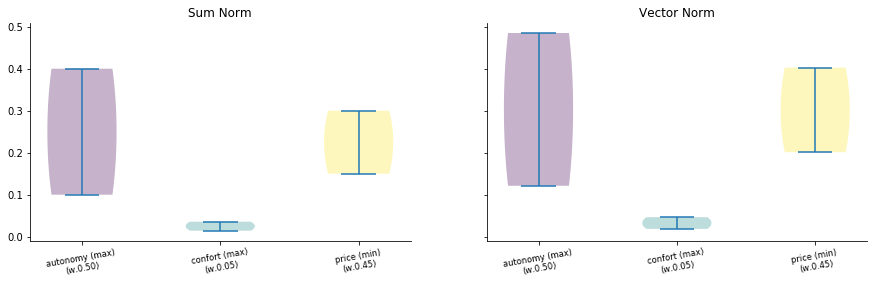

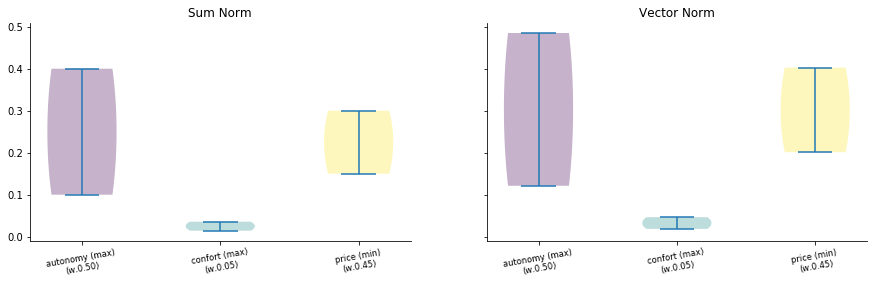

In [9]:
# 2 alternatives by 3 criteria
mtx = [
    [1, 2, 3],  # alternative 1
    [4, 5, 6],  # alternative 2
]
mtx

# let's says the first two alternatives are
# for maximization and the last one for minimization
criteria = [MAX, MAX, MIN]
criteria

data = Data(mtx, criteria)
data

data = Data(mtx, criteria,
            anames=["car 0", "car 1"],
            cnames=["autonomy", "confort", "price"])
data

data = Data(mtx, criteria,
            weights=[.5, .05, .45],
            anames=["car 0", "car 1"],
            cnames=["autonomy", "confort", "price"])
data

# first create the decision maker
# (with the default hiper parameters)
dm = simple.WeightedSum()
dm = simple.WeightedProduct()
dm = closeness.TOPSIS(mnorm="vector")
dm = closeness.TOPSIS(mnorm="sum")


dm

# Now lets decide the ranking
dec = dm.decide(data)
dec

dec.rank_

print(dec.e_)
print("Ideal:", dec.e_.ideal)
print("Anti-Ideal:", dec.e_.anti_ideal)
print("Closeness:", dec.e_.closeness)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_title("Sum Norm")
data.plot.violin(mnorm="sum", ax=ax1);

ax2.set_title("Vector Norm")
data.plot.violin(mnorm="vector", ax=ax2);
f.set_figwidth(15)
plt.show()